In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import ast
from sklearn.model_selection import train_test_split

# Load dataset
df = pd.read_csv("final_combined_mutation_dataset.csv")

# Select relevant columns
df = df[['Encoded_Sequence','Geo_Location','Tissue_Specimen_Source','Collection_Year','Body_Temperature','Parasite_Density','Mutation_Label']]

# Parse stringified lists into actual lists
df['Encoded_Sequence'] = df['Encoded_Sequence'].apply(ast.literal_eval)

# Drop missing rows
df = df.dropna()

# Train-test split
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
features = ['Encoded_Sequence', 'Collection_Year', 'Body_Temperature', 'Parasite_Density']


from sklearn.preprocessing import MinMaxScaler

# Normalize Mutation_Label to [0, 1] for both train and test
scaler = MinMaxScaler()
df_train["Mutation_Label"] = scaler.fit_transform(df_train[["Mutation_Label"]])
df_test["Mutation_Label"] = scaler.transform(df_test[["Mutation_Label"]])


In [4]:
def normalize(df, features, min_val=None, max_val=None):
    scalar_features = [f for f in features if f != 'Encoded_Sequence']  # skip sequence
    
    if min_val is None:
        min_val = df[scalar_features].min()
    if max_val is None:
        max_val = df[scalar_features].max()

    df_norm = df.copy()
    df_norm[scalar_features] = (df[scalar_features] - min_val) / (max_val - min_val + 1e-4)

    return df_norm, min_val, max_val


In [5]:
# ✅ Normalize train and test on same scale
df_train, min_train, max_train = normalize(df_train, features)
df_test, _, _ = normalize(df_test, features, min_val=min_train, max_val=max_train)

In [6]:
from QLSTM import SequenceDataset
from torch.utils.data import DataLoader

sequence_length = 3
batch_size = 32
target = 'Mutation_Label'  # ✅ Add this line to fix the error

train_dataset = SequenceDataset(df_train, target=target, features=features, sequence_length=sequence_length)
test_dataset = SequenceDataset(df_test, target=target, features=features, sequence_length=sequence_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Check
X, y = next(iter(train_loader))
print("✅ Features shape:", X.shape)
print("🎯 Target shape:", y.shape)


✅ Features shape: torch.Size([32, 103])
🎯 Target shape: torch.Size([32])


In [7]:
def train_model(data_loader, model, loss_function, optimizer):
    model.train()
    total_loss = 0
    num_batches = len(data_loader)

    for X, y in data_loader:
        X = X.unsqueeze(1)  # (batch, seq_len=1, features)
        y = y.float()       # make sure target is float for BCELoss
        output = model(X)

        # Match shapes: both should be [batch_size]
        output = output.view_as(y)

        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / num_batches



def test_model(data_loader, model, loss_function): 
    num_batches = len(data_loader)
    total_loss = 0
    model.eval()

    with torch.no_grad():
        for X, y in data_loader:
            X = X.unsqueeze(1)
            y = y.float()
            output = model(X)
            output = output.view_as(y)

            # ✅ Debug print — place *after* model output
            print(f"🧪 Output: {output.detach().numpy()} | Target: {y.numpy()}")

            loss = loss_function(output, y)
            total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")
    return avg_loss



def predict(loader, model):
    model.eval()
    all_preds = []
    with torch.no_grad():
        for batch in loader:
            inputs = batch[0]
            inputs = inputs.unsqueeze(1)  # 🔧 Fix: Add this line
            outputs = model(inputs)
            all_preds.append(outputs.cpu().numpy())
    return np.concatenate(all_preds, axis=0)



In [8]:
import torch
import torch.nn as nn
from QLSTM import ShallowRegressionLSTM

# ✅ Dynamically detect correct number of input features
sample_input, _ = train_dataset[0]
input_size = sample_input.shape[0]

model = ShallowRegressionLSTM(num_sensors=input_size, hidden_units=64)


In [9]:
for X_batch, y_batch in train_loader:
    print("Input shape:", X_batch.shape)  # should be (batch_size, seq_len, num_features)
    break


Input shape: torch.Size([32, 103])


In [10]:
# Count number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters: {num_params}")

Number of parameters: 43329


In [11]:
import torch.nn as nn

# Define loss function and optimizer
loss_function = nn.MSELoss()  # Use nn.BCELoss() if using sigmoid output
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [12]:
classical_loss_train = []
classical_loss_test = []
print("Untrained test\n--------")
# test_loss = test_model(test_loader, model, loss_function)
print()

num_epochs = 150

for ix_epoch in range(num_epochs):
    print(f"Epoch {ix_epoch}\n---------")
    train_loss = train_model(train_loader, model, loss_function, optimizer=optimizer)
    test_loss = test_model(test_loader, model, loss_function)
    classical_loss_train.append(train_loss)
    classical_loss_test.append(test_loss)
   


Untrained test
--------

Epoch 0
---------
🧪 Output: [0.4812485  0.4722444  0.47691193 0.47233272 0.49353474 0.47787738
 0.49527937 0.4610923  0.5064183  0.46886325 0.46464753 0.48799643
 0.4996549  0.47314638 0.5015834  0.4883349  0.45599627 0.47804153
 0.4517069  0.49000448 0.4790128  0.52656823 0.50933117 0.46441224
 0.5140282  0.45729896 0.5015878  0.48571253 0.5091803  0.4657596
 0.46389845 0.49289235] | Target: [0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0.
 1. 0. 0. 0. 1. 1. 0. 1.]
🧪 Output: [0.46587187 0.5108388  0.47516033 0.49683294 0.48235407 0.47801048
 0.48971248 0.4894468  0.5013278  0.4890273  0.49777618 0.52952886
 0.46637973 0.48646048 0.45874304 0.51859736 0.5145555  0.5074608
 0.4885769  0.46308556 0.46890935 0.523375   0.53295493 0.49058917
 0.46747038 0.44448218 0.50108695 0.48918802 0.5034927  0.48543903
 0.4518835  0.4988391 ] | Target: [1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 0. 0. 1. 0. 0. 1. 0.]
🧪 O

In [13]:
predictions = []
model.eval()
with torch.no_grad():
    for X, _ in test_loader:
        X = X.unsqueeze(1)
        output = model(X)
        probs = torch.sigmoid(output).squeeze() * 100  # tensor of size batch_size
        # Convert tensor to list of floats and extend predictions
        predictions.extend(probs.tolist())

df_test["Predicted_Percentage"] = predictions


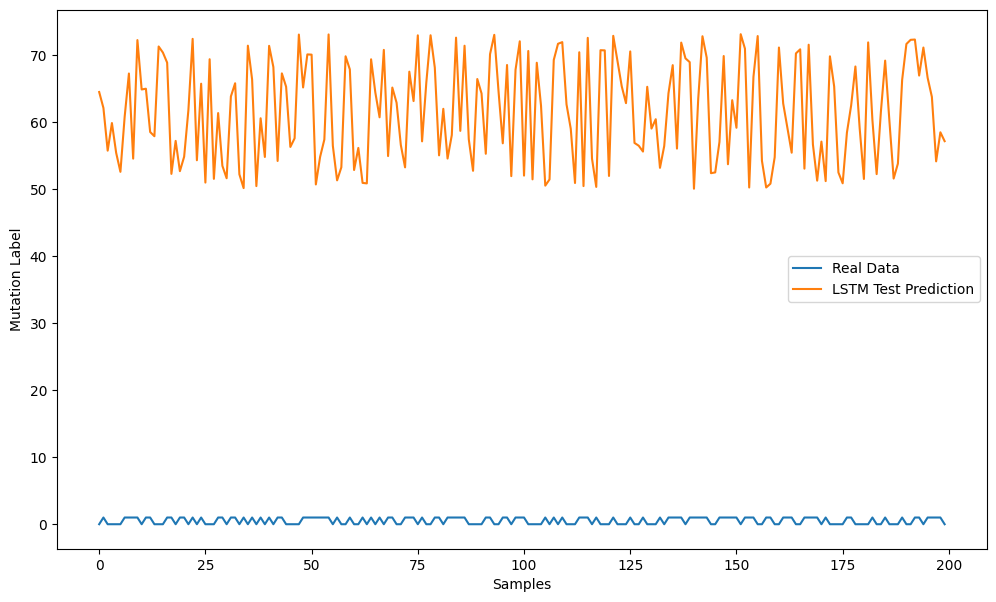

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 7))
plt.plot(range(len(df_test)), df_test['Mutation_Label'], label="Real Data")
plt.plot(range(len(df_test)), df_test["Predicted_Percentage"], label="LSTM Test Prediction")
plt.ylabel('Mutation Label')
plt.xlabel('Samples')
plt.legend()
plt.show()


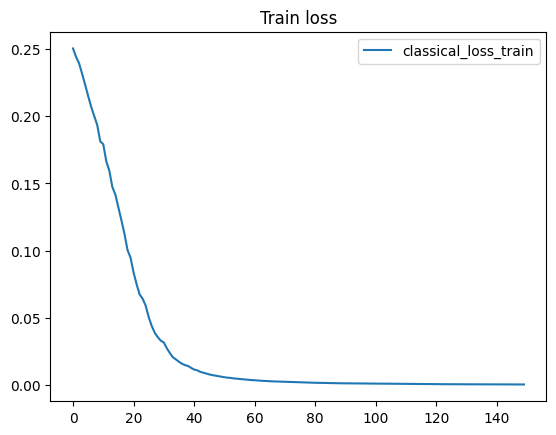

In [15]:
plt.plot(classical_loss_train, label='classical_loss_train')
# plt.plot(classical_loss_test, label='classical_loss_test')
pd.DataFrame(classical_loss_train).to_csv('LSTM_loss.csv', index=False)
plt.title('Train loss')
plt.legend()

In [16]:
import torch
import numpy as np

# Example: your actual input (800 samples, 150 features)
X_train = np.random.rand(800, 150)

# Convert to PyTorch tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)

# Ensure the feature dimension is exactly 103
X_train_tensor = X_train_tensor[:, :103]  # shape: (800, 103)

# Reshape to [batch_size, seq_len, input_size] as expected by the model
# If the model expects a sequence, you can reshape to (batch, seq_len, input_size)
# Here we assume sequence length is 1 if not specified
X_train_tensor = X_train_tensor.unsqueeze(1)  # shape: (800, 1, 103)

# Run inference
model.eval()
with torch.no_grad():
    train_predictions = model(X_train_tensor)


In [17]:
import math
from sklearn.metrics import mean_squared_error

# Calculate RMSE for test data
test_rmse = math.sqrt(mean_squared_error(df_test["Mutation_Label"], df_test["Predicted_Percentage"]))

print(f"Test RMSE: {test_rmse}")
# Assign predictions to df_train (assuming you have model predictions for the train set)
df_train["Predicted_Percentage"] = train_predictions  # Replace `train_predictions` with your actual predictions

# Calculate RMSE for training data
train_rmse = math.sqrt(mean_squared_error(df_train["Mutation_Label"], df_train["Predicted_Percentage"]))

print(f"Train RMSE: {train_rmse}")


Test RMSE: 61.51375031629473
Train RMSE: 0.5271147508083326


In [18]:
print(df_train.columns)
print(df_test.columns)


Index(['Encoded_Sequence', 'Geo_Location', 'Tissue_Specimen_Source',
       'Collection_Year', 'Body_Temperature', 'Parasite_Density',
       'Mutation_Label', 'Predicted_Percentage'],
      dtype='object')
Index(['Encoded_Sequence', 'Geo_Location', 'Tissue_Specimen_Source',
       'Collection_Year', 'Body_Temperature', 'Parasite_Density',
       'Mutation_Label', 'Predicted_Percentage'],
      dtype='object')


In [19]:
# Prepare test input tensor
X_test = np.random.rand(200, 150)  # Replace with your actual test data
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
X_test_tensor = X_test_tensor[:, :103]  # match input size
X_test_tensor = X_test_tensor.unsqueeze(1)  # shape: (batch, seq_len, input_size)

# Run inference
model.eval()
with torch.no_grad():
    test_predictions = model(X_test_tensor)


In [20]:
# Generate predictions
y_pred_train = predict(train_loader, model)
y_pred_test = predict(test_loader, model)

# Assign to DataFrames
df_train["Model Forecast"] = y_pred_train.flatten()
df_test["Model Forecast"] = y_pred_test.flatten()

# Threshold at 0.5
train_class_preds = (df_train["Model Forecast"] > 0.5).astype(float)
test_class_preds = (df_test["Model Forecast"] > 0.5).astype(float)

# Accuracy function
def classification_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

train_acc = classification_accuracy(df_train["Mutation_Label"], train_class_preds)
test_acc = classification_accuracy(df_test["Mutation_Label"], test_class_preds)

print(f"Train classification accuracy: {train_acc:.4f}")
print(f"Test classification accuracy: {test_acc:.4f}")


Train classification accuracy: 0.4800
Test classification accuracy: 0.5250


In [21]:
import torch

features = ["Encoded_Sequence", "Geo_Location", "Body_Temperature"]  # example: adjust as needed
feature_tensors = []

sequence_length = len(df_test.iloc[0]["Encoded_Sequence"])
batch_size = len(df_test)

for feature in features:
    if feature == "Encoded_Sequence":
        tensor = torch.tensor(df_test[feature].tolist(), dtype=torch.float32)  # shape: (batch, seq_len)
    else:
        # Scalar feature: (batch, 1) → repeat along sequence_length to match (batch, seq_len)
        scalar_vals = df_test[feature].values.reshape(-1, 1)
        tensor = torch.tensor(scalar_vals, dtype=torch.float32).repeat(1, sequence_length)
    
    feature_tensors.append(tensor.unsqueeze(-1))  # shape: (batch, seq_len, 1)

# Concatenate along last dimension: final shape (batch, seq_len, num_features)
X_test_tensor = torch.cat(feature_tensors, dim=2)

# Target tensor
y_test_tensor = torch.tensor(df_test["Mutation_Label"].values, dtype=torch.float32)


In [22]:
print("X_test_tensor shape:", X_test_tensor.shape)
print("Model expected input size:", model.lstm.input_size)


X_test_tensor shape: torch.Size([200, 100, 3])
Model expected input size: 103


In [23]:
prediction_scores = y_pred_test.flatten() * 100

output_df = pd.DataFrame({
    "Data_No": range(len(df_test)),
    "Mutation_Label": df_test["Mutation_Label"].values,
    "Predicted_Percentage": prediction_scores
})

output_df.to_csv("LSTM_mutation_prediction_summary.csv", index=False)
print("✅ Saved mutation prediction summary to LSTMmutation_prediction_summary.csv")


✅ Saved mutation prediction summary to LSTMmutation_prediction_summary.csv
